Import libraries

In [1]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape
import fiona
import os
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Save the working directory with data and where you will write the outputs.

In [3]:
wd = "D:/4.LS/MEDPZ/semestralka/final/3+"
rootdir = wd + "/snimek"

Walk through the folder with downloaded satellite imagery and save the B03 and B11 20 m bands into a list named ```source```.

In [4]:
bands_B03 = []
bands_B11 = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if os.path.join(subdir, file).endswith("B03_20m.jp2"):
            bands_B03.append(os.path.join(subdir, file))
        if os.path.join(subdir, file).endswith("B11_20m.jp2"):
            bands_B11.append(os.path.join(subdir, file))

bands_B03

['D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20180701T102021_N0208_R065_T32TMS_20180701T141038.SAFE\\GRANULE\\L2A_T32TMS_A015792_20180701T102404\\IMG_DATA\\R20m\\T32TMS_20180701T102021_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20190716T102031_N0213_R065_T32TMS_20190716T125750.SAFE\\GRANULE\\L2A_T32TMS_A021226_20190716T102028\\IMG_DATA\\R20m\\T32TMS_20190716T102031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20200713T103031_N0214_R108_T32TMS_20200713T132504.SAFE\\GRANULE\\L2A_T32TMS_A026417_20200713T103703\\IMG_DATA\\R20m\\T32TMS_20200713T103031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20210718T103031_N0301_R108_T32TMS_20210718T133950.SAFE\\GRANULE\\L2A_T32TMS_A031708_20210718T103025\\IMG_DATA\\R20m\\T32TMS_20210718T103031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20220713T103041_N0400_R108_T32TMS_20220713T164557.SAFE\\GRANULE\\L2A_T32TMS_A036856_20220713T103035\\IMG

In [5]:
bands_B11

['D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20180701T102021_N0208_R065_T32TMS_20180701T141038.SAFE\\GRANULE\\L2A_T32TMS_A015792_20180701T102404\\IMG_DATA\\R20m\\T32TMS_20180701T102021_B11_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20190716T102031_N0213_R065_T32TMS_20190716T125750.SAFE\\GRANULE\\L2A_T32TMS_A021226_20190716T102028\\IMG_DATA\\R20m\\T32TMS_20190716T102031_B11_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20200713T103031_N0214_R108_T32TMS_20200713T132504.SAFE\\GRANULE\\L2A_T32TMS_A026417_20200713T103703\\IMG_DATA\\R20m\\T32TMS_20200713T103031_B11_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20210718T103031_N0301_R108_T32TMS_20210718T133950.SAFE\\GRANULE\\L2A_T32TMS_A031708_20210718T103025\\IMG_DATA\\R20m\\T32TMS_20210718T103031_B11_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20220713T103041_N0400_R108_T32TMS_20220713T164557.SAFE\\GRANULE\\L2A_T32TMS_A036856_20220713T103035\\IMG

Fill the list ```unique_dates``` with dates of the downloaded satellite images.

In [7]:
unique_dates = []
# loop through the bands in list source
for item in bands_B03:
    # find a date in the band name using regular expression
    match = re.search(r'S2A_[A-Za-z\d]+_(\d+)T', item)
    # if there is a date in the band name
    if match:
        date = match.group(1)
        # add date to the list unique_dates
        unique_dates.append(date)

unique_dates

['20180701', '20190716', '20200713', '20210718', '20220713']

Read geojson file with the area of interest polygon using fiona.open() function. Save its geometry into the ```geometry``` variable. Then create a shape from it and save it in the variable ```input_polygon```.

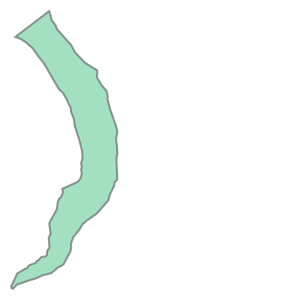

In [10]:
with fiona.open(wd + "/aoi/aoiled.geojson", "r") as shapefile:
    geometry = shapefile[0]["geometry"]
    input_polygon = shape(geometry)

input_polygon

Clip all the ```source``` bands by the ```input_polygon``` which represents the area of interest. Use the [**mask**](https://rasterio.readthedocs.io/en/stable/api/rasterio.mask.html) function. This function returns two elements: 
- *masked*: actual clipped raster
- *out_transform*: information for mapping pixel coordinates in masked to another coordinate system
Save both into their respective lists, *masked* in ```oi``` variable to the ```out_image``` list and *out_transform* into the ```out_transform```  list.

After that save also the metadata of each image band into the ```out_meta``` list using [**meta.copy()**](https://automating-gis-processes.github.io/CSC/notebooks/L5/clipping-raster.html) function.

In [11]:
def clip_raster(bands):    
    out_image = []
    out_transform = []
    out_meta = []
    
    # loop through all the image bands
    for i in range(len(bands)):
        # open the image band as a raster
        with rasterio.open(bands[i]) as src:
            # clipping the current image band by input_polygon
            oi, ot = mask(src, [input_polygon], crop=True)
            out_image.append(oi)
            out_transform.append(ot)
            # retrieve metadata of the current image band
            om = src.meta.copy()
            out_meta.append(om)

        # metadata update of clipped image band
        out_meta[i].update({"driver": "GTiff",
                        "height": out_image[i].shape[1],
                        "width": out_image[i].shape[2],
                        "transform": out_transform[i],
                        "dtype": "float32"
                        })
        out_image[i] = out_image[i].astype('float32')

    return(out_image, out_meta)

[NDSI](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndsi/) (Normalized Difference Snow Index) for Sentinel-2 is calculated like this:

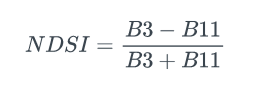

In [12]:
clipped_B03_image, clipped_B03_meta = clip_raster(bands_B03)
clipped_B11_image, clipped_B11_meta = clip_raster(bands_B11)

In [13]:
print(clipped_B03_meta)

[{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}, {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}, {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}, {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}, {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}]


In [14]:
print(clipped_B11_meta)

[{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}, {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}, {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}, {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}, {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 212, 'height': 551, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(20.0, 0.0, 425640.0,
       0.0, -20.0, 5150180.0)}]


In [15]:
glacier_area = []

# let i take values from 0 to half of the source list length 
for i in range(len(clipped_B11_image)):
    # list out_image contains clipped image bands B3 and B11 for all given years 
    # the structure of this list: [year1_B3, year1_B11, year2_B3, year2_B11, ... yearN_B3, yearN_B11]
    # that's why i iterates only "halfway through" the list
    ndsi = (clipped_B03_image[i] - clipped_B11_image[i]) / (clipped_B03_image[i] + clipped_B11_image[i])

    # reclassification: pixels with NDSI greater than 0.42 are assigned value 1 = glacier pixels, the rest is assigned value 0 = no glacier pixels
    ndsi[(ndsi > 0.42)] = 1.0
    ndsi[(ndsi <= 0.42)] = 0.0

    # glacier area calculation: count the number of pixels classified as glacier
    # this number is multiplied by the pixel size, in this case 400 m2, because the image bands have 20 m spatial resolution (20x20=400)
    # then it's divided by 1 million so the final glacier size is in km2
    glacier_pixels_count = np.sum(ndsi == 1.0)
    glacier_area.append((glacier_pixels_count * 400) / 1000000)
    date = unique_dates[i]
    print(f"glacier area on {date[6:] + '.' + date[4:6] + '.' + date[:4]}: {glacier_area[i]} km²")

    # save calculated NDSI as a raster file named ndsi_date.tif
    with rasterio.open(wd + f'/ndsi_{unique_dates[i]}.tif', 'w', **clipped_B03_meta[i]) as dst:
        dst.write(ndsi)

glacier area on 01.07.2018: 12.5324 km²
glacier area on 16.07.2019: 11.8976 km²
glacier area on 13.07.2020: 9.1032 km²
glacier area on 18.07.2021: 11.722 km²
glacier area on 13.07.2022: 8.21 km²


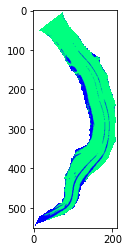

In [34]:
src = rasterio.open(wd + '/ndsi_20180701.tif')
plt.imshow(src.read(1), cmap='winter')
plt.show()

In [16]:
# calculate the difference in glacier area between the first year and last year
difference = glacier_area[0]-glacier_area[len(glacier_area)-1]
if difference > 0:
    print(f"the glacier has shrunk by {difference} km²")
elif difference < 0:
    print(f"the glacier has increased by {abs(difference)} km²")
else:
    print("the glacier hasn't change")

the glacier has shrunk by 4.3224 km²


In [17]:
# fill the list years with years you calculated the glacier area for and the list values with the glacier area in each year
years = []
values = []
for i in range(len(unique_dates)):
    years.append(unique_dates[i][:4])
    values.append(glacier_area[i])

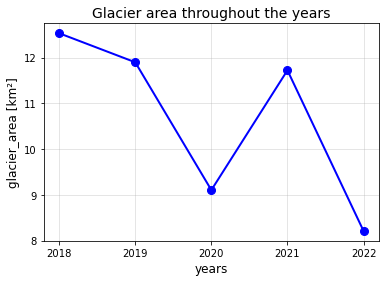

In [18]:
# create a line plot that will show the change in glacier area over the years
plt.plot(years, values, '-o', color='blue', linewidth=2, markersize=8)

# set labels for x and y axes
plt.xlabel('years', fontsize=12)
plt.ylabel('glacier_area [km²]', fontsize=12)

# set title
plt.title('Glacier area throughout the years', fontsize=14)

# set grid
plt.grid(alpha=0.4)

# display the plot
plt.show()